# My Content – Moteur de Recommandation d’Articles

Bienvenue dans ce notebook dédié à la conception d’un premier moteur de recommandation pour la start-up **My Content**.

Notre objectif : **encourager la lecture** en proposant à chaque utilisateur une sélection personnalisée de contenus pertinents.

## Objectif de ce MVP

Ce prototype vise à démontrer une première version fonctionnelle du système de recommandation, fondé sur les interactions passées entre utilisateurs et articles :

> _"En tant qu’utilisateur de l’application, je reçois une sélection de cinq articles adaptés à mes préférences."_

## Données utilisées

Nous exploitons ici des données publiques simulant des interactions réelles entre des utilisateurs et des articles. Elles sont extraites du dataset :

> **[News portal user interactions by Globo.com – Kaggle](https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom)**

Les deux fichiers principaux utilisés :
- `clicks_sample.csv` : historique de clics (utilisateur ↔ article)
- `articles_metadata.csv` : informations descriptives sur les articles (titre, catégorie, etc.)

## Approche de modélisation

Nous commençons par une première approche basée sur le **filtrage collaboratif explicite** en utilisant la librairie **`Surprise`**. Les clics sont transformés en notes implicites (par exemple, nombre de clics par couple utilisateur-article) pour permettre l'entraînement de modèles comme SVD, NMF ou KNN.

Cette première étape permet de tester rapidement plusieurs algorithmes de recommandation classiques sur un format tabulaire simple.

À terme, cette approche pourra évoluer vers :
- un système **hybride** combinant les similarités de contenu (des articles) avec les comportements utilisateurs
- un moteur de recommandation **scalable** intégré à une architecture de production via une API (ex. Azure Functions)

L’objectif est d’explorer différentes méthodes de recommandation, puis de comparer leurs performances sur des métriques communes telles que le Recall, le MRR ou la MAP.

In [2]:
# Bibliothèques standard
import os
import random
import pickle
import logging
from abc import ABC, abstractmethod

# Manipulation de données
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Outils généraux
from itertools import chain, product

# Affichage de barres de progression
from tqdm import tqdm

# Calculs matriciels et similarités
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Split aléatoire
from sklearn.model_selection import train_test_split

# PCA
from sklearn.decomposition import PCA

# Modèles de filtrage collaboratif explicite (Surprise)
from surprise import Dataset, Reader, SVD, NMF, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split

# Modèle de filtrage collaboratif implicite (Implicit)
from implicit.als import AlternatingLeastSquares

# Chargement et exploration des données

Dans cette section, nous allons charger les deux jeux de données principaux :

* Les fichiers horaires `clicks_hour_*.csv`, qui contiennent l’historique complet des interactions entre les utilisateurs et les articles (clics)
* `articles_metadata.csv`, qui contient des informations descriptives sur chaque article

Ces données nous permettront d’analyser le comportement global des utilisateurs et de comprendre la structure et le volume des interactions à modéliser. 

Nous effectuerons également une première exploration pour vérifier la qualité des données et leur adéquation avec les approches de recommandation envisagées.

In [4]:
data_path = 'data/versions/2'

Le dossier `clicks/` contient 24 fichiers (un par heure) représentant les clics utilisateurs sur les articles.  
Nous allons les concaténer pour créer un seul DataFrame complet contenant l’historique global des interactions.

In [6]:
# Dossier contenant les fichiers
clicks_dir = f"{data_path}/clicks/clicks"
clicks_all = []

# Fusionner tous les fichiers
for file in os.listdir(clicks_dir):
    if file.startswith("clicks_hour_") and file.endswith(".csv"):
        path = os.path.join(clicks_dir, file)
        df = pd.read_csv(path)
        clicks_all.append(df)

clicks_df = pd.concat(clicks_all, ignore_index=True)

clicks_df = sample_clicks_df = pd.read_csv(f"{data_path}/clicks_sample.csv")
meta_df = pd.read_csv(f"{data_path}/articles_metadata.csv")

article_ids = clicks_df["click_article_id"].unique()
all_article_ids = meta_df["article_id"].tolist()

In [7]:
#clicks_df = clicks_df.sample(n=10000, random_state=42)

## Aperçu des données

- `clicks_sample.csv` contient les colonnes suivantes :

    - `user_id` : identifiant unique d’un utilisateur
    - `click_article_id` : identifiant de l’article cliqué
    - `session_id`, `click_timestamp`, `click_deviceGroup`, etc. : informations de contexte de navigation

- `articles_metadata.csv` fournit les colonnes suivantes :

    - `article_id` : identifiant de l’article
    - `title` : titre de l’article
    - `category_id`, `publisher_id`, `word_count`, etc.


In [9]:
# Aperçu des données
print("Interactions (clicks_sample.csv)\n")
print(clicks_df.shape)
display(clicks_df.head())

print("\nMétadonnées articles (articles_metadata.csv)\n")
print(clicks_df.shape)
display(meta_df.head())

Interactions (clicks_sample.csv)

(1883, 12)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2



Métadonnées articles (articles_metadata.csv)

(1883, 12)


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


## Statistiques descriptives

Avant d'entraîner notre moteur de recommandation, explorons quelques statistiques clés sur les interactions utilisateur-article.

Nous allons analyser :
- le nombre total de clics
- le nombre d'utilisateurs et d'articles distincts
- la distribution des clics par utilisateur
- les articles les plus populaires


In [11]:
# Nombre total de clics
total_clicks = clicks_df.shape[0]

# Nombre d'utilisateurs et d'articles distincts
n_users = clicks_df["user_id"].nunique()
n_articles_clicked = clicks_df["click_article_id"].nunique()
n_articles_total = meta_df["article_id"].nunique()
n_unique_pairs = clicks_df[["user_id", "click_article_id"]].drop_duplicates().shape[0]
n_total = clicks_df.shape[0]

# Clics par utilisateur
clicks_per_user = clicks_df.groupby("user_id").size()
min_clicks = clicks_per_user.min()
mean_clicks = clicks_per_user.mean()
median_clicks = clicks_per_user.median()
q3_clicks = clicks_per_user.quantile(0.75)
max_clicks = clicks_per_user.max()


# Nombre d'utilisateurs avec plus de 5 et plus de 10 clics
n_above_5 = (clicks_per_user > 5).sum()
n_above_10 = (clicks_per_user > 10).sum()

# Affichage
print(f"Total de clics enregistrés : {total_clicks}")
print(f"Nombre d’utilisateurs uniques : {n_users}")
print(f"Nombre d’articles cliqués : {n_articles_clicked}")
print(f"Nombre total d’articles dans le catalogue : {n_articles_total}")
print(f"Couples user-article uniques : {n_unique_pairs}")
print(f"Moyenne de clics par couple : {n_total / n_unique_pairs:.2f}")
print(f"Nombre de clics par utilisateur :")
print(f"  → min     : {min_clicks}")
print(f"  → moy     : {mean_clicks:.2f}")
print(f"  → médiane : {median_clicks}")
print(f"  → Q3      : {q3_clicks}")
print(f"  → max     : {max_clicks}")
print(f"Nombre d’utilisateurs ayant effectué plus que 5 clicks : {n_above_5}")
print(f"Nombre d’utilisateurs ayant effectué plus que 10 clicks : {n_above_10}")

Total de clics enregistrés : 1883
Nombre d’utilisateurs uniques : 707
Nombre d’articles cliqués : 323
Nombre total d’articles dans le catalogue : 364047
Couples user-article uniques : 1883
Moyenne de clics par couple : 1.00
Nombre de clics par utilisateur :
  → min     : 2
  → moy     : 2.66
  → médiane : 2.0
  → Q3      : 3.0
  → max     : 24
Nombre d’utilisateurs ayant effectué plus que 5 clicks : 22
Nombre d’utilisateurs ayant effectué plus que 10 clicks : 2


In [12]:
# Compter les clics par utilisateur et article
df_counts = clicks_df.groupby(["user_id", "click_article_id"]).size().reset_index(name="rating")

# Aperçu des statistiques
display(df_counts["rating"].describe())

count    1883.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: rating, dtype: float64

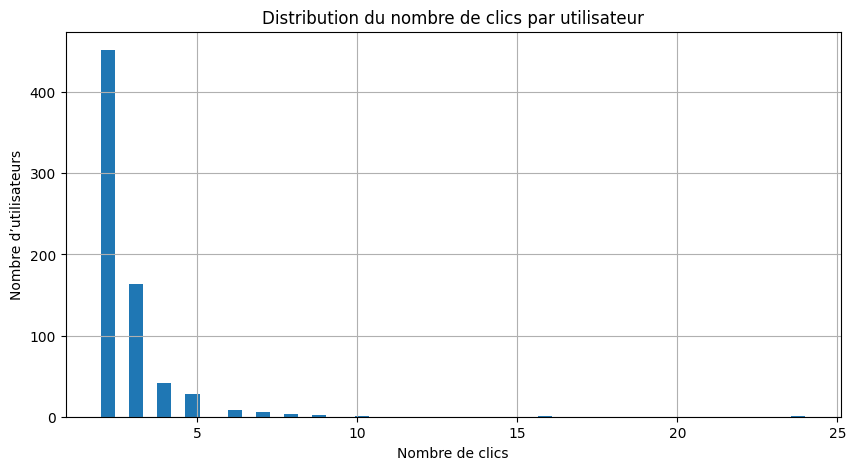

In [13]:
clicks_per_user = clicks_df.groupby("user_id")["click_article_id"].count()

plt.figure(figsize=(10, 5))
clicks_per_user.hist(bins=50)
plt.title("Distribution du nombre de clics par utilisateur")
plt.xlabel("Nombre de clics")
plt.ylabel("Nombre d’utilisateurs")
plt.grid(True)
plt.show()

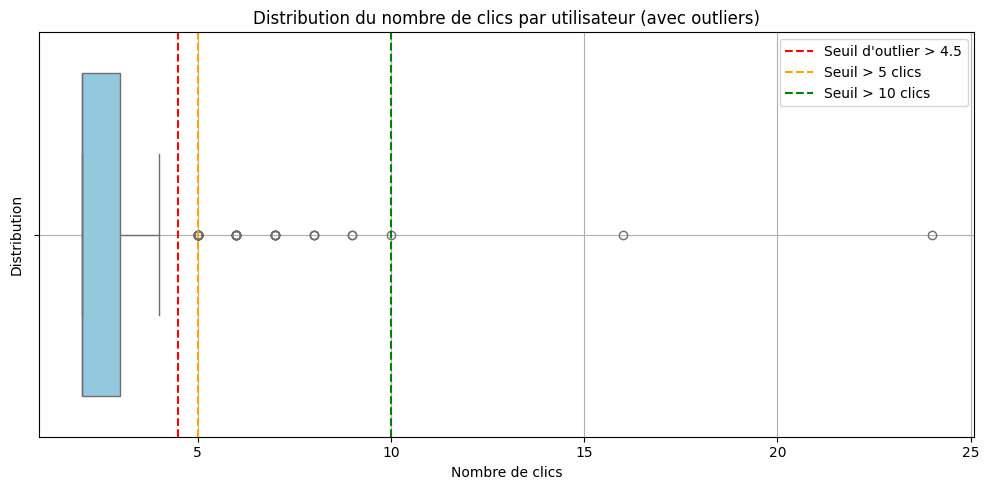

In [14]:
# Recalcul des statistiques
clicks_per_user = clicks_df.groupby("user_id").size()
q1 = clicks_per_user.quantile(0.25)
q3 = clicks_per_user.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identifier les outliers
outliers = clicks_per_user[clicks_per_user > upper_bound]

# Affichage du nombre d'outliers
n_outliers = outliers.shape[0]

# Nouveau style pour la boîte à moustaches dans le style de l'histogramme
plt.figure(figsize=(10, 5))
sns.boxplot(data=clicks_per_user, orient="h", color="skyblue")

# Ajout des lignes de seuil
plt.axvline(upper_bound, color="red", linestyle="--", label=f"Seuil d'outlier > {upper_bound:.1f}")
plt.axvline(5, color="orange", linestyle="--", label="Seuil > 5 clics")
plt.axvline(10, color="green", linestyle="--", label="Seuil > 10 clics")

# Style visuel cohérent avec l'histogramme
plt.title("Distribution du nombre de clics par utilisateur (avec outliers)")
plt.xlabel("Nombre de clics")
plt.ylabel("Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Forcer les types pour éviter le ValueError
clicks_df["click_article_id"] = clicks_df["click_article_id"]
meta_df["article_id"] = meta_df["article_id"]

# Top 10 des articles les plus cliqués
popular_articles = clicks_df["click_article_id"].value_counts().head(10)

# Fusion avec les métadonnées disponibles
popular_articles_df = pd.DataFrame({
    "article_id": popular_articles.index,
    "nb_clicks": popular_articles.values
}).merge(meta_df, how="left", on="article_id")

# Affichage (adapté aux colonnes réelles)
popular_articles_df[["article_id", "category_id", "words_count", "nb_clicks"]]

,article_id,category_id,words_count,nb_clicks
0,119592,247,239,202
1,96663,209,206,153
2,108854,230,167,126
3,284847,412,266,126
4,235840,375,159,106
5,145166,269,180,83
6,68866,136,226,78
7,288431,418,208,71
8,207122,331,1044,49
9,168868,297,147,47


# Modélisation des systèmes de recommandation

Dans cette section, nous comparons plusieurs approches de recommandation en fonction de leur logique, de leurs données d’entrée et de leur comportement :

- **Filtrage collaboratif explicite** : basé sur des notes explicites simulées à partir du nombre de clics. Ces modèles apprennent à prédire la "note" qu’un utilisateur donnerait à un article.

- **Filtrage collaboratif implicite** : basé sur les interactions binaires ou pondérées (clics, vues...), sans note explicite. Ces modèles apprennent des vecteurs latents à partir des comportements partagés entre utilisateurs.

- **Recommandation par popularité** : une baseline simple mais robuste, qui recommande les articles les plus cliqués globalement.

- **Filtrage basé sur le contenu** : recommandations personnalisées basées sur les caractéristiques intrinsèques des articles (textes, catégories, embeddings…).

- **Modèle hybride** : combinaison pondérée de plusieurs sources de recommandation (ici, filtrage collaboratif et content-based) pour améliorer la précision globale.

Chaque sous-section présente le principe de l’approche, la méthode d’entraînement, et une évaluation quantitative selon les mêmes métriques.


In [17]:
# Fonctions utilitaires
def save_model(path, model):
    with open(path, "wb") as f:
        pickle.dump(model, f)

def load_model(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [18]:
#clicks_df = clicks_df.sample(n=50000, random_state=42)

In [19]:
user_encoder = LabelEncoder()
article_encoder = LabelEncoder()

clicks_df["user_enc"] = user_encoder.fit_transform(clicks_df["user_id"])
clicks_df["click_enc"] = article_encoder.fit_transform(clicks_df["click_article_id"])

## Évaluation des modèles de recommandation

Afin de comparer objectivement les performances des différents algorithmes de recommandation testés, nous définissons une classe `RecommenderEvaluator`. Celle-ci permet de calculer plusieurs métriques standards du domaine, basées sur la capacité des modèles à recommander correctement des articles que les utilisateurs ont réellement consultés dans un jeu de test.

L’évaluation est faite de manière personnalisée pour chaque utilisateur :
- On sélectionne les articles avec lesquels l’utilisateur a interagi dans le jeu de test.
- Pour chaque article testé, on échantillonne un ensemble d’articles non vus (négatifs) pour simuler un choix parmi plusieurs options.
- On vérifie ensuite si l’article pertinent apparaît dans le top-N des recommandations produites par le modèle.

Les métriques suivantes sont calculées :
- **Recall@5** et **Recall@10** : proportion d’articles pertinents retrouvés parmi les 5 ou 10 premiers résultats.
- **MRR** (*Mean Reciprocal Rank*) : moyenne des rangs inversés des premiers bons résultats.
- **MAP** (*Mean Average Precision*) : précision moyenne sur les articles pertinents pour chaque utilisateur.

Cette évaluation est appliquée à un échantillon aléatoire d’utilisateurs du jeu de test pour limiter les temps de calcul.


In [21]:
class RecommenderEvaluator:
    def __init__(self, recommender, train_df, test_df, all_article_ids, k=10, n_neg=100):
        """
        recommender : un objet avec une méthode .recommend(user_id, articles_to_rank)
        train_df : DataFrame contenant les clics d'entraînement (user_id, click_article_id)
        test_df : DataFrame contenant les clics de test
        all_article_ids : liste ou array de tous les IDs d'articles possibles
        k : nombre de recommandations à évaluer (Top-k)
        n_neg : nombre d'articles non cliqués à échantillonner pour chaque test
        """
        self.recommender = recommender
        self.train_df = train_df
        self.test_df = test_df
        self.all_articles = set(all_article_ids)
        self.k = k
        self.n_neg = n_neg

    def get_articles_seen(self, user_id, df):
        """
        Retourne l'ensemble des articles vus (cliqués) par un utilisateur dans un DataFrame donné.
        """
        return set(df[df["user_id"] == user_id]["click_article_id"])

    def sample_negative_articles(self, user_id):
        """
        Échantillonne aléatoirement des articles que l'utilisateur n'a jamais vus.
        Sert à créer un ensemble de comparaison négatif.
        """
        seen = self.get_articles_seen(user_id, self.train_df)
        candidates = list(self.all_articles - seen)
        return np.random.choice(candidates, size=self.n_neg, replace=False)

    def average_precision(self, relevant_articles, recommended_articles, topn):
        """
        Calcule la moyenne des précisions pour un utilisateur.
        MAP = Moyenne des précisions aux positions où un article pertinent apparaît.
        """
        hits = 0
        sum_precisions = 0
        for i, article_id in enumerate(recommended_articles[:topn]):
            if article_id in relevant_articles:
                hits += 1
                precision_at_i = hits / (i + 1)
                sum_precisions += precision_at_i
        if hits == 0:
            return 0.0
        return sum_precisions / min(len(relevant_articles), topn)

    def evaluate_user(self, user_id):
        """
        Évalue les performances de la recommandation pour un utilisateur :
        - Recall@k : % des articles pertinents dans le Top-k
        - MRR@k : Reciprocal Rank du premier bon article
        - MAP@k : Moyenne des précisions
        """
        relevant_articles = self.get_articles_seen(user_id, self.test_df)
        if len(relevant_articles) == 0:
            return None

        hits = 0
        mrr = 0
        recommended_articles = []

        # Pour chaque article réellement cliqué, on fait une évaluation simulée
        for true_article in relevant_articles:
            # Échantillon d'articles non cliqués
            negative_sample = self.sample_negative_articles(user_id)
            candidates = list(negative_sample) + [true_article]

            # Obtenir les scores de recommandation sur les articles à classer
            predictions = self.recommender.recommend(user_id, articles_to_rank=candidates)

            # Tri décroissant des articles par score
            ranked_articles = [a for a, score in sorted(predictions.items(), key=lambda x: -x[1])]
            recommended_articles.extend(ranked_articles[:self.k])

            # Si l'article cliqué est dans le Top-k
            if true_article in ranked_articles[:self.k]:
                hits += 1
                rank = ranked_articles.index(true_article)
                mrr += 1 / (rank + 1)

        recall = hits / len(relevant_articles)
        mrr /= len(relevant_articles)
        map_score = self.average_precision(relevant_articles, ranked_articles, self.k)

        return {
            "user_id": user_id,
            f"recall@{self.k}": recall,
            f"mrr@{self.k}": mrr,
            f"map@{self.k}": map_score
        }, recommended_articles

    def evaluate(self, users_subset=None, verbose=False):
        """
        Lance l'évaluation globale sur tous les utilisateurs du jeu de test
        (ou un sous-ensemble si précisé).
        Renvoie :
        - les métriques moyennes globales
        - un DataFrame avec les métriques par utilisateur
        """
        users = self.test_df["user_id"].unique() if users_subset is None else users_subset
        results = []
        recommendations = {}

        for user_id in tqdm(users, desc="Évaluation Top-N"):
            metrics, recs = self.evaluate_user(user_id)
            if metrics:
                results.append(metrics)
                recommendations[user_id] = recs

        df = pd.DataFrame(results)

        # Coverage calculation
        all_recommended = set(chain.from_iterable(recommendations.values()))
        coverage = len(all_recommended) / len(self.all_articles)

        global_metrics = {
            "name": self.recommender.get_name(),
            f"avg_recall@{self.k}": df[f"recall@{self.k}"].mean(),
            f"avg_mrr@{self.k}": df[f"mrr@{self.k}"].mean(),
            f"avg_map@{self.k}": df[f"map@{self.k}"].mean(),
            f"coverage@{self.k}": coverage
        }

        return global_metrics, df

In [22]:
class BaseRecommender(ABC):
    """
    Classe de base pour tous les modèles de recommandation.
    Chaque modèle doit implémenter la méthode `recommend(user_id, articles_to_rank)`.
    """

    @abstractmethod
    def get_name(self):
        """
        Retourne un nom lisible du modèle (ex: "Content-Based", "ALS", etc.).
        """
        pass

    @abstractmethod
    def recommend(self, user_id, articles_to_rank):
        """
        Prend un user_id et une liste d'IDs d'articles à scorer,
        retourne un dictionnaire {article_id: score}.

        articles_to_rank : list[int]
        return : dict[int, float]
        """
        pass

## Filtrage collaboratif explicite

Le filtrage collaboratif explicite repose sur des modèles de factorisation matricielle, entraînés à partir de **notes explicites** ou de **valeurs estimées** (par exemple, le nombre de clics agrégés par utilisateur et par article). Ces modèles apprennent à prédire la "préférence" d’un utilisateur pour un article donné, même s’il ne l’a jamais consulté, en exploitant les interactions observées dans la base de données.

Nous utilisons ici la librairie `Surprise`, spécialisée dans la recommandation à partir de données tabulaires au format `(utilisateur, item, rating)`. Les modèles comme **SVD**, **NMF** ou **KNNWithMeans** peuvent y être entraînés, puis évalués selon les mêmes métriques que les autres approches.

Pour rendre ces modèles compatibles avec notre classe d’évaluation commune `ModelEvaluator`, nous définissons une classe d'encapsulation `SurpriseRecommenderWrapper`. Celle-ci fournit une méthode `recommend_items()` permettant de générer des recommandations filtrées et triées pour un utilisateur donné, dans le même format que les autres modèles.

L'évaluation est ainsi homogénéisée, ce qui permet une comparaison directe entre filtrage explicite, implicite, content-based, et approches hybrides.


In [24]:
class SurpriseRecommender(BaseRecommender):
    def __init__(self, model, model_name, user_encoder, article_encoder):
        """
        model : modèle entraîné avec Surprise (ex. SVD, NMF)
        model_name : nom du modèle pour affichage
        user_encoder : encoder sklearn pour les user_id
        article_encoder : encoder sklearn pour les click_article_id
        """
        self.model = model
        self.model_name = model_name
        self.user_encoder = user_encoder
        self.article_encoder = article_encoder

    def get_name(self):
        return self.model_name

    def recommend(self, user_id, articles_to_rank):
        """
        Prédit les scores de préférence pour chaque article demandé.
        Retourne un dictionnaire {article_id: predicted_score}
        """
        if user_id not in self.user_encoder.classes_:
            return {article_id: 0.0 for article_id in articles_to_rank}

        user_enc = self.user_encoder.transform([user_id])[0]

        predictions = {}
        for article_id in articles_to_rank:
            if article_id not in self.article_encoder.classes_:
                predictions[article_id] = 0.0
                continue

            article_enc = self.article_encoder.transform([article_id])[0]
            pred = self.model.predict(str(user_enc), str(article_enc))
            predictions[article_id] = pred.est

        return predictions

Les modèles de la librairie `Surprise` attendent des données au format `(utilisateur, article, note)` pour fonctionner. Dans notre cas, nous ne disposons pas de notes explicites, mais uniquement de clics. Nous allons donc estimer une note implicite en comptant le nombre de clics par couple `(utilisateur, article)`.

Ce nombre de clics est ensuite utilisé comme **rating** pour entraîner les modèles. Optionnellement, une transformation logarithmique pourrait être appliquée pour atténuer l’impact des utilisateurs très actifs, mais ici nous conservons la valeur brute.

Nous réalisons ensuite un découpage aléatoire en jeu d’entraînement et de test (25% des données pour le test). Le format de données est ensuite adapté :
- `train_df` est utilisé pour entraîner les modèles de type SVD ou NMF via `Surprise`.
- `clicks_train` et `clicks_test` sont utilisés pour évaluer tous les modèles dans une structure unifiée.
- `article_ids` contient la liste unique des identifiants d’articles, nécessaire à la classe `ModelEvaluator`.

Enfin, nous préparons `trainset` et `testset` dans les formats attendus par `Surprise` : un `Trainset` interne pour l’entraînement, et une liste de tuples pour l’évaluation.

In [26]:
# Compter les clics par couple utilisateur-article
df_counts = clicks_df.groupby(["user_id", "click_article_id"]).size().reset_index(name="rating")

# Renommage pour la librairie Surprise
df_counts.columns = ["user", "article", "rating"]

# Facultatif : normalisation logarithmique des clics pour réduire le biais des utilisateurs très actifs
# df_counts["rating"] = np.log1p(df_counts["rating"])

# Split explicite entraînement / test
train_df, test_df = train_test_split(df_counts, test_size=0.25, random_state=42)

# Renommage pour le pipeline standard
clicks_train = train_df.rename(columns={"user": "user_id", "article": "click_article_id"})
clicks_test = test_df.rename(columns={"user": "user_id", "article": "click_article_id"})

# Liste unique des articles
article_ids = df_counts["article"].unique()

In [27]:
# Train SVD sur train_df
reader = Reader(rating_scale=(df_counts["rating"].min(), df_counts["rating"].max()))

trainset = Dataset.load_from_df(train_df, reader).build_full_trainset()

print(f"Nombre d'utilisateurs : {trainset.n_users}")
print(f"Nombre d'articles : {trainset.n_items}")
print(f"Plage de ratings : {df_counts['rating'].min()} → {df_counts['rating'].max()}")

Nombre d'utilisateurs : 677
Nombre d'articles : 266
Plage de ratings : 1 → 1


### Singular Value Decomposition (SVD)

Dans cette section, nous entraînons un premier moteur de recommandation basé sur l’algorithme **SVD**, une méthode classique du filtrage collaboratif reposant sur la *factorisation matricielle*.

Le principe consiste à représenter chaque utilisateur et chaque article dans un *espace latent commun*, défini par un ensemble de dimensions cachées. Ces dimensions peuvent refléter des préférences implicites : par exemple, un intérêt pour certains sujets (technologie, politique, sport…) ou des types de contenus.

Le modèle estime la préférence d’un utilisateur pour un article donné en mesurant la proximité entre leurs représentations dans cet espace latent, généralement à l’aide d’un *produit scalaire entre vecteurs*. Cela permet de capturer des affinités même si l’utilisateur n’a jamais interagi directement avec l’article.

Nous utilisons ici l’implémentation de **SVD** proposée par la librairie `Surprise`, qui repose sur une *descente de gradient* pour minimiser l’erreur entre les valeurs d’interactions observées (clics) et les valeurs prédites.

L’entraînement est réalisé sur **75 %** des données, tandis que **25 %** sont utilisées pour évaluer la performance via la métrique **RMSE** (*Root Mean Squared Error*).
Un RMSE faible indique une bonne capacité du modèle à approximer les préférences implicites des utilisateurs.

Le moteur de recommandation que nous allons entraîner repose sur une approche de **filtrage collaboratif implicite**, dans laquelle les clics des utilisateurs sont utilisés comme indicateurs d’intérêt.

Nous utilisons la librairie `Surprise`, qui attend une structure de données au format **(user, item, rating)**.
Dans notre cas, le champ `rating` correspond à un **score implicite dérivé du comportement utilisateur**, généralement basé sur la fréquence des clics observés pour chaque couple *(utilisateur, article)*.

Ainsi, plus un utilisateur clique sur un article, plus le score associé sera élevé.
Les articles jamais cliqués ne sont pas inclus dans l’entraînement, ce qui signifie que le modèle apprend uniquement à partir des interactions positives observées.

In [29]:
# Entraînement
svd_model = SVD()
svd_model.fit(trainset)

# Sauvegarde du modèle
save_model("models/svd_model.pkl", svd_model)

In [30]:
svd_recommender = SurpriseRecommender(
    model=svd_model, 
    model_name="SVD",
    user_encoder=user_encoder,
    article_encoder=article_encoder
)

evaluator = RecommenderEvaluator(
    recommender=svd_recommender,
    train_df=clicks_train,
    test_df=clicks_test,
    all_article_ids=set(clicks_df["click_article_id"].unique()),
    k=10
)

svd_metrics, svd_detailed = evaluator.evaluate()

print("\nÉvaluation du modèle SVD (Surprise)")
print("----------------------------------------------------")
for k, v in svd_metrics.items():
    print(f"{k:<20} : {v:.4f}" if isinstance(v, float) else f"{k:<20} : {v}")

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:12<00:00, 27.29it/s]


Évaluation du modèle SVD (Surprise)
----------------------------------------------------
name                 : SVD
avg_recall@10        : 0.0264
avg_mrr@10           : 0.0058
avg_map@10           : 0.0062
coverage@10          : 1.0000


### Non-negative Matrix Factorization (NMF)

Dans cette section, nous testons un second modèle de factorisation : **NMF**, pour *Non-negative Matrix Factorization*.
Contrairement au SVD, le NMF impose que toutes les composantes des vecteurs latents soient **positives**, ce qui le rend particulièrement adapté aux cas où les interactions sont **implicites, unilatéralement positives**, comme les clics, les vues ou les achats.

Le principe du NMF est de représenter la matrice utilisateur-article comme le produit de deux matrices non négatives, chacune correspondant à une représentation latente des utilisateurs et des articles. Les préférences sont alors modélisées comme une combinaison additive de facteurs interprétables, ce qui rend ce modèle intéressant pour des analyses qualitatives.

Le modèle NMF de la librairie `Surprise` suit le même principe d’entraînement que le SVD, mais sans inclure de biais utilisateur ou article. Il est optimisé par descente de gradient et utilise par défaut 15 facteurs latents, 50 itérations, et des coefficients de régularisation sur les deux matrices à ajuster selon le jeu de données.

Cette approche permet de capturer les préférences sous forme de pondérations positives tout en évitant l’interprétation de signaux négatifs qui n’existent pas dans les données implicites.

In [32]:
# Initialisation et entraînement du modèle
nmf_model = NMF()
nmf_model.fit(trainset)

In [33]:
nmf_recommender = SurpriseRecommender(
    model=nmf_model, 
    model_name="NMF",
    user_encoder=user_encoder,
    article_encoder=article_encoder
)

evaluator = RecommenderEvaluator(
    recommender=nmf_recommender,
    train_df=clicks_train,
    test_df=clicks_test,
    all_article_ids=set(clicks_df["click_article_id"].unique()),
    k=10
)

nmf_metrics, nmf_detailed = evaluator.evaluate()

print("\nÉvaluation du modèle NMF (Surprise)")
print("----------------------------------------------------")
for k, v in nmf_metrics.items():
    print(f"{k:<20} : {v:.4f}" if isinstance(v, float) else f"{k:<20} : {v}")

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:12<00:00, 28.09it/s]


Évaluation du modèle NMF (Surprise)
----------------------------------------------------
name                 : NMF
avg_recall@10        : 0.0238
avg_mrr@10           : 0.0104
avg_map@10           : 0.0093
coverage@10          : 1.0000


### Filtrage collaboratif par similarité et moyenne (KNNWithMeans)

Le modèle `KNNWithMeans` repose sur le principe du **filtrage collaboratif à base de voisinage**, où la préférence d’un utilisateur pour un article est estimée à partir des préférences d’utilisateurs ou d’articles similaires.

Contrairement à la méthode KNN classique, ce modèle introduit une correction par la **moyenne des notes** données, afin de prendre en compte les biais individuels des utilisateurs (certains notent systématiquement plus haut ou plus bas que la moyenne).

Deux approches sont possibles selon l’orientation choisie :

* en mode *user-based*, on identifie les utilisateurs similaires à l’utilisateur cible ;
* en mode *item-based*, on identifie les articles similaires à l’article cible.

Dans les deux cas, le modèle calcule une **matrice de similarité** (par exemple avec la distance cosinus ou la corrélation de Pearson), sélectionne les *k* éléments les plus proches, et en déduit une estimation de la préférence par pondération.

Nous utilisons ici l’implémentation de `KNNWithMeans` proposée par la librairie `Surprise`, avec la possibilité de choisir la méthode de similarité et l’orientation (utilisateur ou article). Le modèle ne nécessite pas d’apprentissage au sens strict : il construit la matrice de similarité à partir des données d’interactions, puis effectue les prédictions à la volée.

In [35]:
# Configuration et entraînement du modèle
sim_options = {
    "name": "cosine",
    "user_based": False  # Similarité entre articles
}

knn_means_model = KNNWithMeans(sim_options=sim_options, verbose=True)
knn_means_model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [36]:
knn_means_recommender = SurpriseRecommender(
    model=knn_means_model, 
    model_name="KNNWithMeans",
    user_encoder=user_encoder,
    article_encoder=article_encoder
)

evaluator = RecommenderEvaluator(
    recommender=knn_means_recommender,
    train_df=clicks_train,
    test_df=clicks_test,
    all_article_ids=set(clicks_df["click_article_id"].unique()),
    k=10
)

knn_means_metrics, knn_means_detailed = evaluator.evaluate()

print("\nÉvaluation du modèle KNNWithMeans (Surprise)")
print("----------------------------------------------------")
for k, v in knn_means_metrics.items():
    print(f"{k:<20} : {v:.4f}" if isinstance(v, float) else f"{k:<20} : {v}")

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:10<00:00, 34.92it/s]



Évaluation du modèle KNNWithMeans (Surprise)
----------------------------------------------------
name                 : KNNWithMeans
avg_recall@10        : 0.0237
avg_mrr@10           : 0.0058
avg_map@10           : 0.0058
coverage@10          : 1.0000


## Recommandation par popularité (baseline)

L’approche Popularity-Based repose sur un principe simple mais souvent efficace : recommander à tous les utilisateurs les articles les plus populaires, c’est-à-dire ceux qui ont été le plus fréquemment cliqués, consultés ou achetés dans l’ensemble du système.

Ce modèle ne cherche pas à personnaliser les recommandations selon le profil ou l’historique de chaque utilisateur. Au contraire, il se base uniquement sur des statistiques agrégées à l’échelle globale. En d’autres termes, les mêmes articles sont proposés à tous, à l’exception de ceux que l’utilisateur a déjà vus (et qui peuvent être ignorés si désiré).

Dans le cadre d’un système de recommandation basé sur les clics, la popularité d’un article est souvent mesurée comme le nombre total de clics reçus sur une période donnée. Cette fréquence peut être calculée simplement à partir d’un `groupby` sur l’identifiant de l’article.

Bien que cette méthode ne soit ni personnalisée ni contextuelle, elle présente plusieurs avantages :

* **Robustesse** : aucune dépendance à un historique utilisateur ou à une structure complexe.
* **Rapidité** : pas de phase d’apprentissage, résultats immédiats dès que les données sont disponibles.
* **Résilience au cold start utilisateur** : fonctionne même lorsqu’un utilisateur n’a encore interagi avec aucun article.

En revanche, cette stratégie souffre de biais forts :

* **Biais de popularité** : les articles déjà populaires ont tendance à rester recommandés en boucle.
* **Absence de diversité** : tous les utilisateurs voient les mêmes suggestions, ce qui peut limiter la découverte de contenu.

Cette approche est souvent utilisée comme **baseline** pour comparer les performances de modèles plus sophistiqués (collaboratifs ou content-based). Elle peut aussi servir de fallback dans les systèmes hybrides, notamment pour les nouveaux utilisateurs ou lors de panne de modèles plus complexes.


In [38]:
# Split user-based
def split_clicks_df(df, test_size=0.25):
    train_rows = []
    test_rows = []
    total_users = df["user_id"].nunique()
    for i, (user_id, user_df) in enumerate(df.groupby("user_id")):
        if len(user_df) < 2:
            train_rows.append(user_df)
            continue
        train, test = train_test_split(user_df, test_size=test_size, random_state=42)
        train_rows.append(train)
        test_rows.append(test)
    return pd.concat(train_rows), pd.concat(test_rows)

clicks_train, clicks_test = split_clicks_df(clicks_df)

In [39]:
class PopularityRecommender(BaseRecommender):
    def __init__(self, interactions_df):
        """
        Modèle basé sur la popularité (nombre total de clics par article).
        """
        self.popularity_df = (
            interactions_df["click_article_id"]
            .value_counts()
            .reset_index()
            .rename(columns={"count": "click_count"})
        )        
        # Dictionnaire article_id → score
        self.popularity_scores = dict(
            zip(self.popularity_df["click_article_id"], self.popularity_df["click_count"])
        )

    def get_name(self):
        return "Popularity-Based"

    def recommend(self, user_id, articles_to_rank):
        """
        Retourne un dictionnaire {article_id: score} pour les articles demandés.
        """
        res = {
            article_id: self.popularity_scores.get(article_id, 0.0)
            for article_id in articles_to_rank
        }
        return res

In [40]:
# Création du modèle de popularité
pop_recommender = PopularityRecommender(interactions_df=clicks_train)

# Identification des articles populaires (cliqués > 5 fois dans le test)
article_freq = clicks_test["click_article_id"].value_counts()
most_popular_articles = article_freq[article_freq > 5].index

# Évaluation 1 : test complet (avec articles populaires)
evaluator_all = RecommenderEvaluator(
    recommender=pop_recommender,
    train_df=clicks_train,
    test_df=clicks_test,
    all_article_ids=set(clicks_df["click_article_id"].unique()),
    k=10
)
pop_metrics, pop_detailed = evaluator_all.evaluate()

# Évaluation 2 : test filtré (sans articles trop populaires)
filtered_test = clicks_test[~clicks_test["click_article_id"].isin(most_popular_articles)]

evaluator_filtered = RecommenderEvaluator(
    recommender=pop_recommender,
    train_df=clicks_train,
    test_df=filtered_test,
    all_article_ids=set(clicks_df["click_article_id"].unique()),
    k=10
)
pop_metrics_filtered, pop_detailed_filtered = evaluator_filtered.evaluate()

# Affichage comparatif
print("\nÉvaluation du modèle Popularité")
print("----------------------------------------------------")
print("Test complet (avec articles populaires) :")
for k, v in pop_metrics.items():
    print(f"{k:<20} : {v:.4f}" if isinstance(v, float) else f"{k:<20} : {v}")

print("\nTest filtré (sans articles trop populaires > 5 clics) :")
for k, v in pop_metrics_filtered.items():
    print(f"{k:<20} : {v:.4f}" if isinstance(v, float) else f"{k:<20} : {v}")


Évaluation Top-N: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 1317.31it/s]


Évaluation du modèle Popularité
----------------------------------------------------
Test complet (avec articles populaires) :
name                 : Popularity-Based
avg_recall@10        : 0.7443
avg_mrr@10           : 0.4437
avg_map@10           : 0.4387
coverage@10          : 0.1827

Test filtré (sans articles trop populaires > 5 clics) :
name                 : Popularity-Based
avg_recall@10        : 0.1598
avg_mrr@10           : 0.0247
avg_map@10           : 0.0243
coverage@10          : 0.1796


## Filtrage collaboratif implicite

### Alternating Least Squares (ALS)

L’algorithme ALS repose sur une méthode de factorisation matricielle spécialement conçue pour les **données implicites**, comme les clics, les vues ou les achats, où l’on ne dispose pas de notes explicites de préférence. Ce modèle est particulièrement utilisé dans les environnements industriels, notamment chez des acteurs comme Spotify ou Amazon, en raison de sa **scalabilité** et de sa robustesse sur de grands volumes de données.

Contrairement aux modèles de la librairie `Surprise`, qui sont adaptés aux données explicites (par exemple des notes de 1 à 5), ALS fonctionne avec des signaux unilatéralement positifs. C’est pourquoi nous utilisons ici la librairie `implicit`, conçue spécifiquement pour ce cas d’usage. Elle permet de pondérer les interactions en fonction de leur fréquence, de gérer des matrices creuses très grandes, et d’accélérer les calculs grâce à l’utilisation facultative de GPU.

Le modèle apprend deux matrices latentes : une pour les utilisateurs, une pour les articles. À chaque itération, les vecteurs d’un côté sont fixés pendant que l’autre est optimisé via une résolution par moindres carrés, puis l’opération est inversée jusqu’à convergence. L’algorithme tient compte de la **confiance** associée à chaque interaction (plus un utilisateur clique sur un article, plus l’information est considérée comme fiable) tout en pénalisant les erreurs sur les interactions absentes.

Le modèle `AlternatingLeastSquares` attend une **matrice utilisateur-article au format sparse CSR**, avec des identifiants **entiers encodés** pour les utilisateurs et les articles. Chaque cellule de cette matrice contient une pondération (par exemple le nombre de clics).
La préparation des données consiste donc à :

* convertir les identifiants en indices entiers via un encodage
* construire une matrice creuse en utilisant `scipy.sparse.csr_matrix`

Cette représentation est bien adaptée aux grands jeux de données implicites et permet d’entraîner un modèle de recommandation efficace sans avoir recours à des notes explicites.

In [42]:
# Encodage des identifiants utilisateurs et articles en entiers
user_encoder = LabelEncoder()
article_encoder = LabelEncoder()

clicks_train["train_user_enc"] = user_encoder.fit_transform(clicks_train["user_id"])
clicks_train["train_article_enc"] = article_encoder.fit_transform(clicks_train["click_article_id"])

# Nombre total d'utilisateurs et d'articles
n_users = clicks_train["train_user_enc"].nunique()
n_articles = clicks_train["train_article_enc"].nunique()

# Construction de la matrice utilisateur-article
interaction_values = [1] * len(clicks_train)
user_article_matrix = sp.csr_matrix(
    (interaction_values, (clicks_train["train_user_enc"], clicks_train["train_article_enc"])),
    shape=(n_users, n_articles)
)

print(f"Matrice utilisateur-article créée : {user_article_matrix.shape}")

Matrice utilisateur-article créée : (707, 237)


Nous entraînons ici le modèle `ALS` à partir de la matrice CSR d’interactions implicites.  

In [44]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"

from threadpoolctl import threadpool_limits
threadpool_limits(1, "blas")

In [45]:
# Implémentation compatible avec RecommenderEvaluator
class ALSRecommender(BaseRecommender):
    def __init__(self, model, user_encoder, article_encoder, user_article_matrix):
        self.model = model
        self.user_encoder = user_encoder
        self.article_encoder = article_encoder
        self.user_article_matrix = user_article_matrix

    def get_name(self):
        return "Alternating Least Squares (ALS)"
        
    def recommend(self, user_id, articles_to_rank):
        if user_id not in self.user_encoder.classes_:
            return {article_id: 0.0 for article_id in articles_to_rank}

        user_enc = self.user_encoder.transform([user_id])[0]

        # Garder uniquement les articles qu’on sait encoder
        valid_articles = [a for a in articles_to_rank if a in self.article_encoder.classes_]
        article_encs = self.article_encoder.transform(valid_articles)
        enc_to_article = {enc: self.article_encoder.inverse_transform([enc])[0] for enc in article_encs}

        # Prédiction ALS = produit scalaire user × article
        user_vec = self.model.user_factors[user_enc]
        article_vecs = self.model.item_factors[article_encs]
        scores = user_vec @ article_vecs.T

        return {enc_to_article[enc]: float(score) for enc, score in zip(article_encs, scores)}

In [46]:
param_grid = {
    "factors": [20, 50, 100],
    "regularization": [0.001, 0.01, 0.1],
    "iterations": [10, 20]
}

best_score = 0
best_model = None
best_params = None

for f, reg, it in product(param_grid["factors"], param_grid["regularization"], param_grid["iterations"]):
    print(f"Test: factors={f}, reg={reg}, iter={it}")
    
    model = AlternatingLeastSquares(factors=f, regularization=reg, iterations=it, random_state=42)
    model.fit(user_article_matrix)

    recommender = ALSRecommender(model, user_encoder, article_encoder, user_article_matrix)

    evaluator = RecommenderEvaluator(
        recommender=recommender,
        train_df=clicks_train,
        test_df=clicks_test,
        all_article_ids=clicks_df["click_article_id"].unique(),
        k=10
    )

    score, _ = evaluator.evaluate()
    current_map = score["avg_map@10"]
    print(f"Score: {current_map}")
    
    if current_map > best_score:
        best_score = current_map
        best_model = model
        best_params = (f, reg, it)

print("\nBest avg_map@10:", round(best_score, 4))
print("Best Params:", best_params)

Test: factors=20, reg=0.001, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 68.58it/s]

Score: 0.05804455445544555
Test: factors=20, reg=0.001, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 64.63it/s]

Score: 0.05545873464897509
Test: factors=20, reg=0.01, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:12<00:00, 56.27it/s]

Score: 0.054587814223599235
Test: factors=20, reg=0.01, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:11<00:00, 60.04it/s]


Score: 0.05309462068655846
Test: factors=20, reg=0.1, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 65.53it/s]

Score: 0.07633612851081027
Test: factors=20, reg=0.1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 67.65it/s]

Score: 0.07542741519049864
Test: factors=50, reg=0.001, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 68.78it/s]

Score: 0.02787010843941537
Test: factors=50, reg=0.001, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:12<00:00, 58.20it/s]

Score: 0.033466637480074536
Test: factors=50, reg=0.01, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:13<00:00, 51.80it/s]

Score: 0.028827372533171684
Test: factors=50, reg=0.01, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 67.53it/s]

Score: 0.031170719112727598
Test: factors=50, reg=0.1, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 65.76it/s]

Score: 0.06093683347926629
Test: factors=50, reg=0.1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 70.04it/s]

Score: 0.056561651063065495
Test: factors=100, reg=0.001, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 66.27it/s]

Score: 0.02066354594643138
Test: factors=100, reg=0.001, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:13<00:00, 50.93it/s]

Score: 0.024952291147482097
Test: factors=100, reg=0.01, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:11<00:00, 59.96it/s]

Score: 0.020411530949013268
Test: factors=100, reg=0.01, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 69.92it/s]

Score: 0.022507633416402863
Test: factors=100, reg=0.1, iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 69.66it/s]

Score: 0.06040951033878899
Test: factors=100, reg=0.1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:10<00:00, 66.67it/s]

Score: 0.0569123111290721

Best avg_map@10: 0.0763
Best Params: (20, 0.1, 10)


In [47]:
# Entraînement du modèle ALS
factors, regularization, iterations = best_params

als_model = AlternatingLeastSquares(
    factors=factors,
    regularization=regularization,
    iterations=iterations,
    random_state=42
)

als_model.fit(user_article_matrix)
print("Modèle ALS entraîné avec succès.")

  0%|          | 0/10 [00:00<?, ?it/s]

Modèle ALS entraîné avec succès.


In [48]:
# Création du modèle
als_recommender = ALSRecommender(
    model=als_model,
    user_encoder=user_encoder,
    article_encoder=article_encoder,
    user_article_matrix=user_article_matrix
)

# Évaluation avec RecommenderEvaluator
evaluator = RecommenderEvaluator(
    recommender=als_recommender,
    train_df=clicks_train,
    test_df=clicks_test,
    all_article_ids=set(clicks_df["click_article_id"].unique()),
    k=10
)

als_metrics, als_detailed = evaluator.evaluate()

print("\nÉvaluation du modèle ALS")
print("----------------------------------------------------")
for k, v in als_metrics.items():
    print(f"{k:<20} : {v:.4f}" if isinstance(v, float) else f"{k:<20} : {v}")

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:13<00:00, 51.54it/s]


Évaluation du modèle ALS
----------------------------------------------------
name                 : Alternating Least Squares (ALS)
avg_recall@10        : 0.3914
avg_mrr@10           : 0.0844
avg_map@10           : 0.0819
coverage@10          : 0.4892


## Filtrage basé sur le contenu (Embeddings d’articles)

Dans cette section, nous explorons une approche de **filtrage par le contenu**, qui repose uniquement sur les caractéristiques des articles eux-mêmes. Contrairement aux méthodes collaboratives qui s’appuient sur les interactions utilisateurs, le filtrage content-based permet de recommander des articles similaires à ceux déjà consultés, sans avoir besoin de données sur les autres utilisateurs.

Nous utilisons pour cela un fichier `articles_embeddings.pickle`, qui contient pour chaque article un **vecteur d’embedding dense**. Ces vecteurs, généralement obtenus à partir de modèles de traitement du langage (par exemple Word2Vec ou BERT), permettent de représenter le contenu sémantique des articles dans un espace vectoriel.

L’idée est simple : pour un utilisateur donné, on identifie les articles qu’il a déjà lus, on calcule la moyenne de leurs vecteurs d’embedding, puis on mesure la **similarité cosinus** entre ce vecteur moyen et tous les autres articles du catalogue. Les articles les plus similaires sont alors proposés comme recommandations.

Ce type de moteur est particulièrement utile dans les cas suivants :

* lorsque l’on veut faire des recommandations **indépendantes des autres utilisateurs** ;
* dans des situations de **cold start utilisateur** (ex. nouvel inscrit sans historique) ;
* ou en complément d’un modèle collaboratif dans un système **hybride**.

La seule condition est de disposer de représentations vectorielles fiables et cohérentes du contenu des articles.

In [50]:
# Chargement des embeddings d'articles
with open(f"{data_path}/articles_embeddings.pickle", "rb") as f:
    article_embeddings = pickle.load(f)
    
assert len(article_embeddings) == len(meta_df["article_id"].tolist()), "Mismatch between embeddings and article IDs"

In [51]:
# Modèle de recommandation basé sur le contenu (articles)
class ContentBasedRecommender:
    def __init__(self, article_ids, article_embeddings, interactions_df):
        self.article_ids = np.array(article_ids)
        self.article_embeddings = article_embeddings
        self.interactions_df = interactions_df
        self.article_index = {article_id: idx for idx, article_id in enumerate(article_ids)}

    def get_name(self):
        return 'Content-Based'
    
    def recommend(self, user_id, articles_to_rank):
        seen_articles = set(self.interactions_df[self.interactions_df["user_id"] == user_id]["click_article_id"])
        seen_idxs = [self.article_index[a] for a in seen_articles if a in self.article_index]
        if not seen_idxs:
            return {article_id: 0.0 for article_id in articles_to_rank}
        user_profile = self.article_embeddings[seen_idxs].mean(axis=0)
        user_profile = user_profile / np.linalg.norm(user_profile)
        scores = {}
        for article_id in articles_to_rank:
            if article_id in self.article_index:
                idx = self.article_index[article_id]
                article_vec = self.article_embeddings[idx]
                article_vec = article_vec / np.linalg.norm(article_vec)
                scores[article_id] = np.dot(user_profile, article_vec)
            else:
                scores[article_id] = 0.0
        return scores

In [52]:
# Création du modèle content-based
cb_recommender = ContentBasedRecommender(
    article_ids=article_ids,
    article_embeddings=article_embeddings,
    interactions_df=clicks_train  
)

# Évaluation avec la classe ArticleRecommenderEvaluator (renommée précédemment)
evaluator = RecommenderEvaluator(
    recommender=cb_recommender,
    train_df=clicks_train,
    test_df=clicks_test,
    all_article_ids=set(clicks_df["click_article_id"].unique()),
    k=10
)

# Évaluation et affichage des résultats
cb_metrics, cb_detailed = evaluator.evaluate()

print("\nÉvaluation du modèle Content-based")
print("----------------------------------------------------")
for k, v in cb_metrics.items():
    print(f"{k:<20} : {v:.4f}" if isinstance(v, float) else f"{k:<20} : {v}")

Évaluation Top-N: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:01<00:00, 391.10it/s]


Évaluation du modèle Content-based
----------------------------------------------------
name                 : Content-Based
avg_recall@10        : 0.2442
avg_mrr@10           : 0.0931
avg_map@10           : 0.0924
coverage@10          : 0.9133


# Comparaison des résultats

Cette section présente une analyse comparative des différents modèles de recommandation testés sur notre jeu de données. 

L’objectif est de comprendre leur comportement respectif selon plusieurs métriques clés et de dégager des enseignements sur leurs points forts et leurs limites.

Les métriques choisies permettent d’évaluer à la fois la pertinence des recommandations et leur capacité à couvrir une variété d’articles.

- Le **recall@k** permet de mesurer la proportion des articles cliqués qui sont bien retrouvés dans les k premiers résultats recommandés. C’est un indicateur direct de la capacité du modèle à reproduire les préférences utilisateurs.
  
- Le **MAP@k** (Mean Average Precision) offre une vision plus fine en prenant en compte la position des articles pertinents dans la liste recommandée. Un bon modèle ne se contente pas de retrouver les bons articles, il les place idéalement en tête de liste.
  
- Le **MRR@k** (Mean Reciprocal Rank) s’intéresse à la position du tout premier article pertinent. Il est particulièrement utile pour des cas d’usage où l’on souhaite que l’utilisateur clique dès les premières suggestions.
  
- Enfin, le **coverage@k** mesure la proportion d’articles différents recommandés à l’ensemble des utilisateurs. Un coverage élevé traduit une bonne capacité du modèle à explorer le catalogue et à personnaliser les recommandations.

In [54]:
comparatif_df = pd.DataFrame([
    svd_metrics,
    nmf_metrics,
    knn_means_metrics,
    pop_metrics,
    pop_metrics_filtered,
    cb_metrics,
    als_metrics
]).set_index("name")

# Arrondir pour lecture
comparatif_df = comparatif_df.round(4)

# Tri par recall
comparatif_df.sort_values('avg_recall@10', ascending=False, inplace=True)

# Afficher
display(comparatif_df)

,avg_recall@10,avg_mrr@10,avg_map@10,coverage@10
name,,,,
Popularity-Based,0.7443,0.4437,0.4387,0.1827
Alternating Least Squares (ALS),0.3914,0.0844,0.0819,0.4892
Content-Based,0.2442,0.0931,0.0924,0.9133
Popularity-Based,0.1598,0.0247,0.0243,0.1796
SVD,0.0264,0.0058,0.0062,1.0000
NMF,0.0238,0.0104,0.0093,1.0000
KNNWithMeans,0.0237,0.0058,0.0058,1.0000


Le modèle **Popularity-Based** atteint un très bon **recall\@10 de 0.74** et un **MAP\@10 de 0.43**, car il recommande systématiquement les articles les plus cliqués. Mais sa **coverage\@10 est faible (0.18)**, car tous les utilisateurs reçoivent quasiment les mêmes recommandations. Lorsqu’on retire les articles populaires du test, ses performances chutent fortement, avec un **recall\@10 de seulement 0.16**, confirmant sa dépendance à quelques articles dominants.

Le modèle **ALS** propose un **recall\@10 de 0.38** et une **coverage\@10 de 0.49**, ce qui en fait un bon compromis entre pertinence et diversité. Cependant, ses scores en **MAP\@10 (0.0758)** et **MRR\@10 (0.0785)** restent limités.

Le modèle **Content-Based** se distingue par une **coverage\@10 élevée (0.90)** et une performance stable (**recall\@10 de 0.25**, **MAP\@10 de 0.10**, **MRR\@10 de 0.10**). Il personnalise mieux les recommandations et reste performant même sans dépendre des articles populaires.

En conclusion, **Content-Based** est le modèle le plus adapté pour une première mise en production : il combine robustesse, diversité et pertinence, là où Popularity est efficace mais peu adaptable, et ALS encore un peu limité.

On va maintenant mesurer pour chaque modèle ses performances en fonction de la taille du Top-k recommandé (par exemple : `k=5`, `k=10`, `k=20`, `k=30`). 

On va visualiser l’évolution de ces métriques en fonction de k pour chaque modèle, ainsi que des comparaisons directes entre modèles à un instant donné (par exemple recall@10). 

Ces graphiques permettent de mettre en lumière les dynamiques propres à chaque approche : certains modèles sont très efficaces pour retrouver des articles populaires, d'autres proposent une plus grande diversité mais au prix d’un rappel plus faible.

Cette comparaison nous aide à mieux comprendre les compromis entre performance brute, personnalisation et diversité, et constitue une base solide pour orienter les choix futurs de modèles selon les priorités métiers (précision vs découverte).

In [56]:
# Simuler la liste des k à tester
ks = [5, 10, 20, 30]

# Simuler les recommenders déjà créés (utilise des placeholders pour démo)
recommenders = {
    "Content-Based": cb_recommender,
    "ALS": als_recommender,
    "Popularity": pop_recommender,
    "SVD": svd_recommender,
    "NMF": nmf_recommender,
    "KNNWithMeans": knn_means_recommender
}

# Stockage intelligent sous forme de DataFrame
records = []

for model_name, recommender in recommenders.items():
    for k in ks:
        evaluator = RecommenderEvaluator(
            recommender=recommender,
            train_df=clicks_train,
            test_df=clicks_test,
            all_article_ids=set(clicks_df["click_article_id"].unique()),
            k=k
        )
        metrics, _ = evaluator.evaluate()
        records.append({
            "model": model_name,
            "k": k,
            "recall": metrics[f"avg_recall@{k}"],
            "map": metrics[f"avg_map@{k}"],
            "mrr": metrics[f"avg_mrr@{k}"],
            "coverage": metrics.get(f"coverage@{k}", None)
        })

# Convertir en DataFrame pour plotting
eval_k_df = pd.DataFrame(records)

Évaluation Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:18<00:00, 37.56it/s]


## Comparaison visuelle des modèles de recommandation

Le graphique ci-dessous illustre l’évolution comparative des performances des différents modèles selon trois métriques clés : `recall`, `map` (mean average precision) et `coverage`, pour différentes valeurs de `k` (nombre d’articles recommandés).

Chaque ligne du graphique correspond à une métrique, et chaque colonne à une valeur de `k`. Cette visualisation permet de :

- Mieux percevoir la progression (ou stagnation) des performances de chaque modèle à mesure que l'on augmente la taille du Top-k.
- Identifier les modèles les plus efficaces pour capter les clics utilisateurs (`recall`), ceux qui placent les bons articles le plus haut possible (`map`), et ceux qui offrent la plus grande diversité de recommandations (`coverage`).


In [58]:
def plot_model_comparison_by_k(df, metric="recall", ks=[5, 10, 20]):
    """
    Affiche un subplot horizontal par valeur de k pour une métrique donnée.
    
    df : DataFrame avec colonnes ['model', 'k', 'recall', 'map', 'mrr', 'coverage']
    metric : nom de la métrique à tracer (ex: 'recall')
    ks : liste des valeurs de k à afficher
    """
    n = len(ks)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5 * n, 4), sharey=True)

    for i, k in enumerate(ks):
        ax = axes[i] if n > 1 else axes
        df_k = df[df["k"] == k]#.sort_values(metric, ascending=True)
        ax.barh(df_k["model"], df_k[metric], color='cornflowerblue')
        ax.set_title(f"{metric}@{k}")
        ax.set_xlabel(metric)
        ax.grid(axis='x', linestyle='--', alpha=0.6)
        if i == 0:
            ax.set_ylabel("Modèle")

    plt.suptitle(f"Comparaison des modèles par '{metric}' pour différentes valeurs de k", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

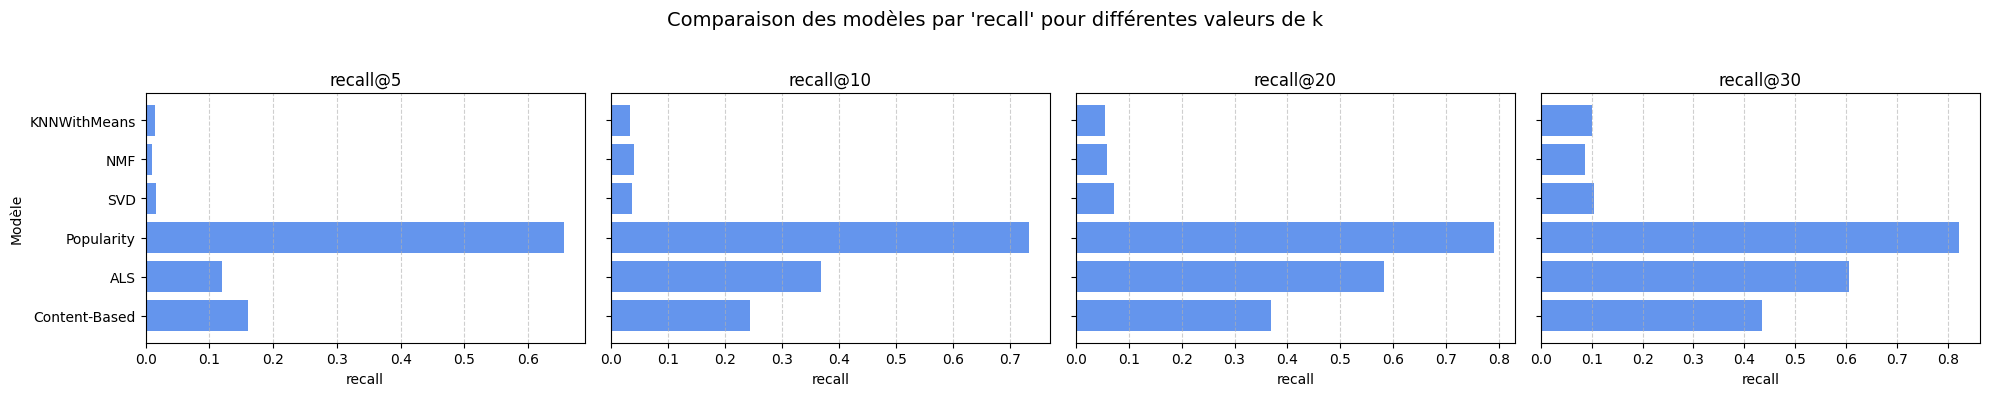

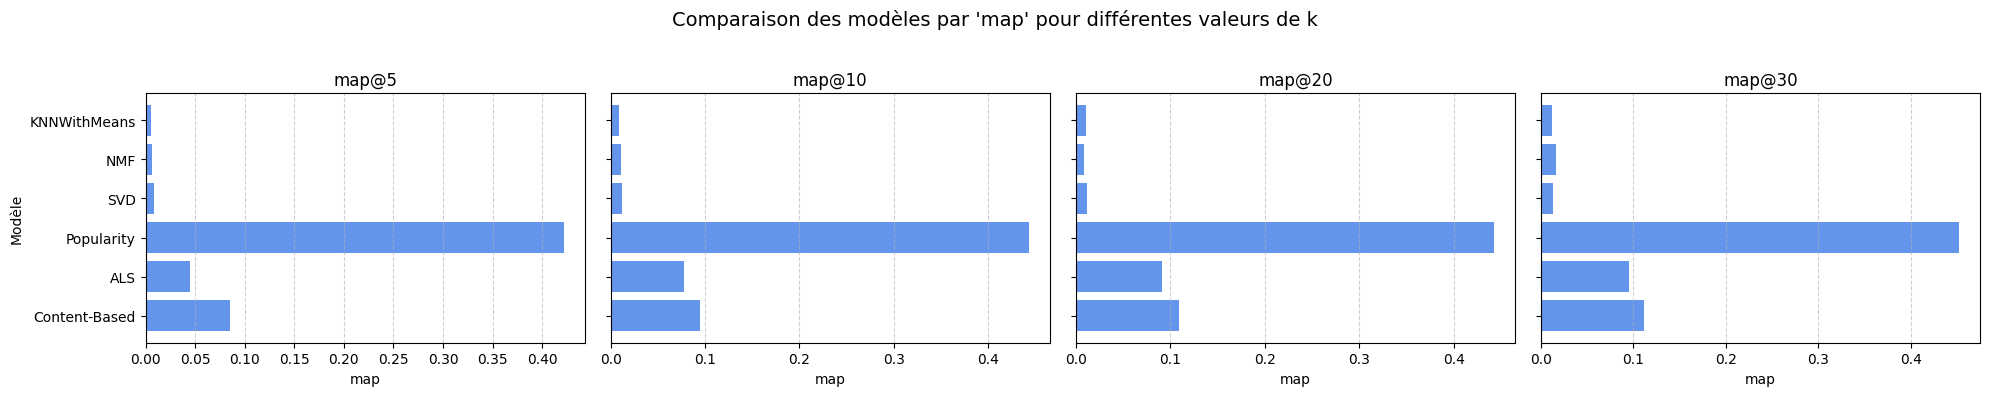

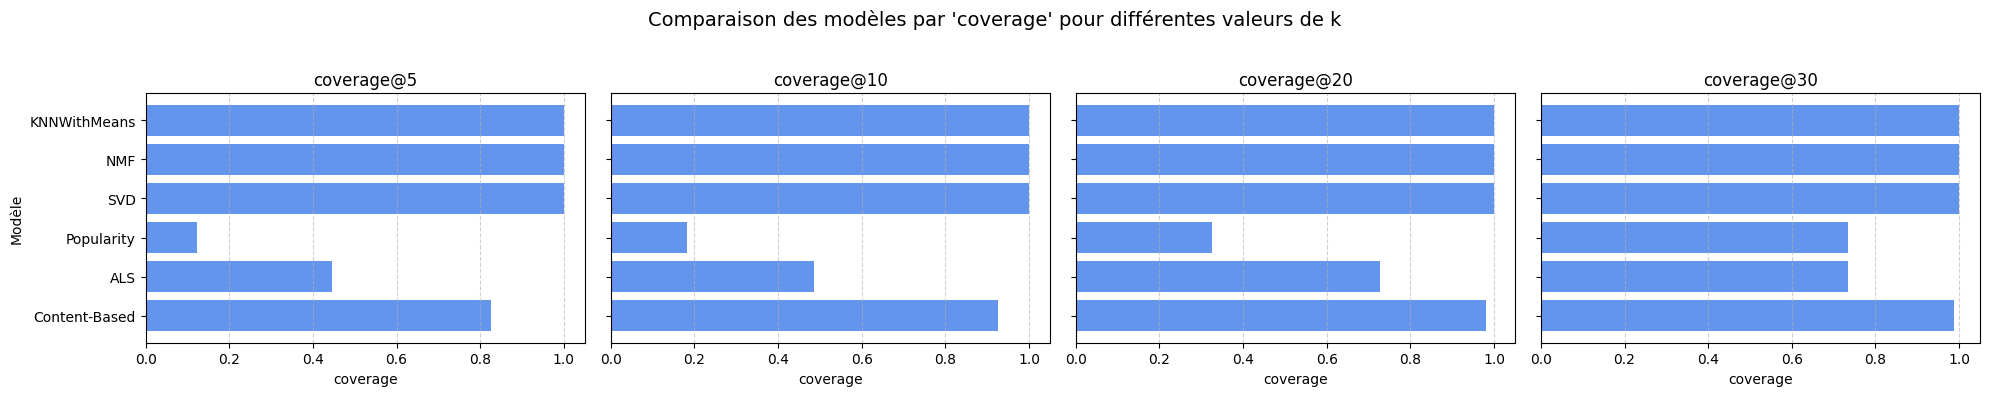

In [59]:
plot_model_comparison_by_k(eval_k_df, metric="recall", ks=ks)
plot_model_comparison_by_k(eval_k_df, metric="map", ks=ks)
plot_model_comparison_by_k(eval_k_df, metric="coverage", ks=ks)


On observe par exemple que :
- Le modèle **Popularity-Based** domine en `recall` et `map`, mais au prix d’un `coverage` très limité.
- Le modèle **Content-Based** présente un bon équilibre entre couverture et pertinence.
- Les modèles **SVD**, **NMF** et **KNNWithMeans** restent faibles sur toutes les métriques, indiquant qu’ils ne sont pas adaptés dans ce contexte.
- Le modèle **ALS** offre une couverture modérée et un rappel correct, mais reste en retrait par rapport aux autres en `map`.

Cette analyse comparative aide à orienter le choix du modèle selon les priorités métier : privilégier la précision brute ou maximiser la découverte et la diversité.


## Recommandation stratégique

Les résultats présentés mettent en évidence des différences notables entre les modèles de recommandation. Le modèle basé sur la popularité (**Popularity-Based**) se distingue par ses très bonnes performances en `recall@k` et `map@k`. 

Cela s’explique par le fait qu’il recommande systématiquement les articles les plus cliqués dans l’ensemble du dataset. 

Cette stratégie est efficace lorsque les articles populaires du test sont également présents dans les recommandations — ce qui est souvent le cas lorsque les utilisateurs interagissent avec des contenus très visibles ou mis en avant.

Cependant, nous avons montré dans une évaluation complémentaire que **si on retire ces articles populaires du test**, les performances de ce modèle chutent drastiquement. 

Cela révèle une **dépendance forte à quelques articles dominants**, et surtout, une **incapacité à personnaliser les recommandations**. 

Le modèle popularity tend à proposer **exactement les mêmes articles à tous les utilisateurs**, ce qui explique son **coverage extrêmement faible**. 

En pratique, cela signifie qu’un utilisateur peu aligné avec les tendances générales recevra des recommandations peu pertinentes.

En comparaison :
- Le modèle **Content-Based** offre des performances plus modestes en termes de `recall`, mais avec un bien meilleur `coverage`, ce qui reflète une meilleure capacité à adapter les recommandations aux préférences individuelles.
- Le modèle **ALS**, basé sur le filtrage collaboratif implicite, présente également un bon compromis entre personnalisation et pertinence, bien qu’un peu moins performant que le content-based en couverture.

On va donc retenir le modèle **Content-Based** pour une utilisation en production dans un premier temps. Il présente les avantages suivants :
- Il est **robuste** face à la dominance des articles populaires.
- Il **ne dépend pas d’un grand historique d’interactions** utilisateur.
- Il propose une **couverture élevée**, ce qui favorise la découverte de nouveaux contenus.
- Il est facile à maintenir.

Cependant, à mesure que la base d’utilisateurs et les volumes d’interactions augmenteront, le modèle **ALS** pourrait devenir une alternative ou un complément intéressant, notamment dans une approche hybride personnalisé.

## Évolution des performances du modèle Content-Based

Le graphique ci-dessous montre l’évolution des performances du modèle Content-Based en fonction de la taille du top-k recommandé.

On observe que :
- **Le recall@k progresse régulièrement** avec la taille du top-k, passant de **0.15 à 0.42 entre k=5 et k=30**. Cela montre que plus on élargit les recommandations, plus le modèle parvient à retrouver les articles cliqués par l’utilisateur.
- **Le MAP@k (précision moyenne) atteint un maximum à k=20 (~0.11)**, puis diminue légèrement. Cela suggère que les articles pertinents sont en général bien classés jusqu'à un certain seuil, après quoi l’élargissement du top-k apporte des articles moins bien classés.
- **La coverage@k est très élevée dès k=10 (~0.95)** et atteint **plus de 0.99 à k=30**, confirmant que ce modèle recommande une grande variété d’articles à l’ensemble des utilisateurs.

Ces résultats confirment la capacité du modèle Content-Based à proposer des recommandations personnalisées, diversifiées et globalement pertinentes, en particulier autour de k=10 à k=20.

In [61]:
def plot_metric_evolution(df, model_name, metric="recall"):
    """
    Trace l'évolution d'une métrique (recall, map, mrr, coverage) en fonction de k pour un modèle donné.
    
    df : DataFrame contenant au moins les colonnes ['model', 'k', <metric>]
    model_name : nom du modèle à filtrer (str)
    metric : nom de la métrique à tracer (str)
    """
    subset = df[df["model"] == model_name]
    subset = subset.sort_values("k")

    plt.figure(figsize=(6, 4))
    plt.plot(subset["k"], subset[metric], marker='o', color='royalblue')
    plt.xlabel("k")
    plt.ylabel(f"{metric}@k")
    plt.title(f"{metric}@k pour le modèle {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

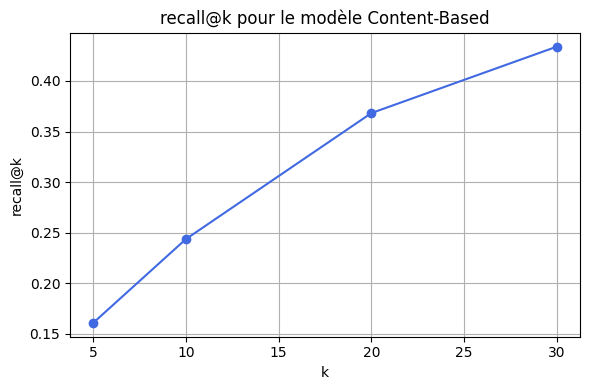

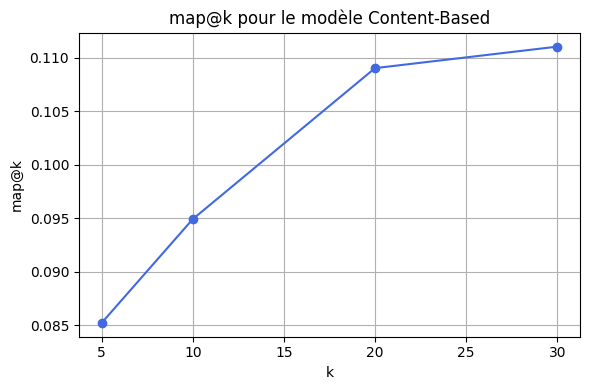

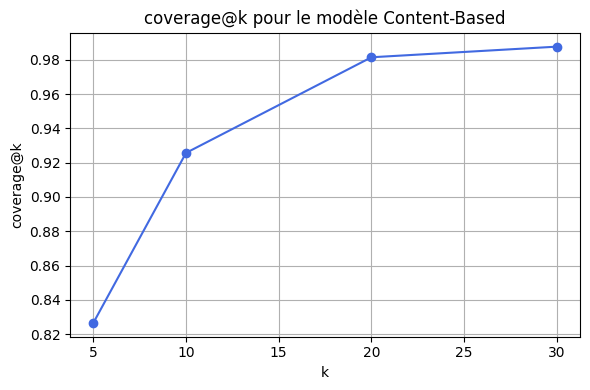

In [62]:
plot_metric_evolution(eval_k_df, model_name="Content-Based", metric="recall")
plot_metric_evolution(eval_k_df, model_name="Content-Based", metric="map")
plot_metric_evolution(eval_k_df, model_name="Content-Based", metric="coverage")

# Génération de recommandations personnalisées

Pour intégrer notre modèle Content-Based dans un environnement de production, comme une Azure Function ou une API, nous avons encapsulé le processus de recommandation dans une fonction simple et réutilisable.

Cette fonction `recommend_articles_for_user()` prend en entrée :
- l’identifiant de l’utilisateur,
- une instance du modèle content-based déjà entraîné,
- une liste d’articles à classer,
- et un paramètre `topn` pour définir le nombre de recommandations à retourner.

Elle retourne une liste d’identifiants d’articles, classés par pertinence décroissante pour l’utilisateur.

Cette fonction est compatible avec une mise en production dans un service d’inférence (Azure Function, API FastAPI, etc.). Elle peut facilement être adaptée pour retourner des métadonnées (titres, images) si nécessaire.


In [64]:
def recommend_articles_for_user(user_id, model, articles_to_rank, topn=10):
    """
    Génère une liste d'articles recommandés pour un utilisateur donné à l’aide d’un modèle Content-Based.

    Arguments :
    - user_id : identifiant de l'utilisateur (str ou int)
    - model : instance du modèle Content-Based (doit implémenter .recommend(user_id, articles_to_rank))
    - articles_to_rank : liste des articles disponibles à classer
    - topn : nombre de recommandations à retourner (par défaut 10)

    Retour :
    - Une liste ordonnée d’identifiants d’articles recommandés
    """
    scores = model.recommend(user_id, articles_to_rank)
    sorted_articles = sorted(scores.items(), key=lambda x: -x[1])
    recommended_ids = [article_id for article_id, _ in sorted_articles[:topn]]
    return pd.DataFrame(sorted_articles[:topn], columns=["article_id", "score"])

In [65]:
user_id = 0

all_articles = set(clicks_df["click_article_id"].unique())
seen = set(clicks_df[clicks_df["user_id"] == user_id]["click_article_id"])
articles_to_rank = list(all_articles - seen)

recommend_articles_for_user(0, cb_recommender, articles_to_rank)

,article_id,score
0,202436,0.748907
1,284346,0.748769
2,66457,0.743452
3,207122,0.737914
4,198420,0.732637
5,166553,0.730792
6,236294,0.730299
7,288431,0.712244
8,286413,0.706825
9,254816,0.695695


# Réduction des embeddings pour déploiement Azure

Avant de déployer le modèle Content-Based dans Azure Function, nous avons réduit la taille du fichier `articles_embeddings.pickle`, qui contenait les vecteurs d’articles, afin de respecter les limites imposées par l’environnement serverless.

Le fichier d'origine pesait environ **250 Mo**, ce qui le rendait peu optimal pour un déploiement dans Azure Function (plan de consommation). 

L’objectif était donc de réduire sa taille tout en conservant une information suffisante pour la recommandation.

Nous avons utilisé une **réduction de dimension par ACP (PCA)** pour compresser les embeddings tout en préservant l’essentiel de leur structure vectorielle.

* Méthode : `sklearn.decomposition.PCA`
* Dimensions initiales : 250
* Dimensions finales : 50
* Format de sortie : fichier `articles_embeddings_pca.pickle`

| Fichier                              | Dimensions | Taille   |
| ------------------------------------ | ---------- | -------- |
| `articles_embeddings.pickle`         | (N, 250)   | \~355 Mo |
| `articles_embeddings_pca.pickle` | (N, 50)    | \~71 Mo  |

Le modèle Content-Based a ensuite été adapté pour charger ce fichier réduit, ce qui permet un démarrage rapide de l’API, un déploiement fluide et un respect des limites du plan gratuit Azure.

In [67]:
# Chargement des embeddings
with open(f"{data_path}/articles_embeddings.pickle", "rb") as f:
    embeddings = pickle.load(f)

print(f"Shape initiale : {embeddings.shape}")  # (N, D)

# Réduction via PCA
n_components = 50
pca = PCA(n_components=n_components)
embeddings_reduced = pca.fit_transform(embeddings)

print(f"Shape réduite : {embeddings_reduced.shape}")

# Sauvegarde dans un nouveau fichier
with open(f"{data_path}/articles_embeddings_pca.pickle", "wb") as f:
    pickle.dump(embeddings_reduced, f)

print(f"Fichier réduit enregistré : {data_path}/articles_embeddings_pca.pickle")

Shape initiale : (364047, 250)
Shape réduite : (364047, 50)
Fichier réduit enregistré : data/versions/2/articles_embeddings_pca.pickle


In [68]:
# Chargement des embeddings d'articles reduits
with open(f"{data_path}/articles_embeddings_pca.pickle", "rb") as f:
    article_embeddings_pca = pickle.load(f)
    
assert len(article_embeddings_pca) == len(meta_df["article_id"].tolist()), "Mismatch between embeddings and article IDs"

# Création du modèle content-based
cb_recommender_pca = ContentBasedRecommender(
    article_ids=article_ids,
    article_embeddings=article_embeddings_pca,
    interactions_df=clicks_train  
)

In [69]:
# Simuler la liste des k à tester
ks = [5, 10, 20, 30]

# Simuler les recommenders déjà créés (utilise des placeholders pour démo)
recommenders = {
    "Content-Based": cb_recommender,
    "Content-Based PCA": cb_recommender_pca,
}

# Stockage intelligent sous forme de DataFrame
records = []

for model_name, recommender in recommenders.items():
    for k in ks:
        evaluator = RecommenderEvaluator(
            recommender=recommender,
            train_df=clicks_train,
            test_df=clicks_test,
            all_article_ids=set(clicks_df["click_article_id"].unique()),
            k=k
        )
        metrics, _ = evaluator.evaluate()
        records.append({
            "model": model_name,
            "k": k,
            "recall": metrics[f"avg_recall@{k}"],
            "map": metrics[f"avg_map@{k}"],
            "mrr": metrics[f"avg_mrr@{k}"],
            "coverage": metrics.get(f"coverage@{k}", None)
        })

# Convertir en DataFrame pour plotting
cb_eval_k_df = pd.DataFrame(records)

Évaluation Top-N: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:01<00:00, 448.00it/s]


In [70]:
cb_eval_k_df

,model,k,recall,map,mrr,coverage
0,Content-Based,5,0.155587,0.078689,0.079397,0.829721
1,Content-Based,10,0.244224,0.091130,0.091421,0.900929
2,Content-Based,20,0.361858,0.102900,0.102959,0.965944
3,Content-Based,30,0.443423,0.108425,0.109644,0.984520
4,Content-Based PCA,5,0.153701,0.085090,0.085899,0.835913
5,Content-Based PCA,10,0.235502,0.093870,0.094316,0.916409
6,Content-Based PCA,20,0.342999,0.104554,0.105558,0.975232
7,Content-Based PCA,30,0.417963,0.105213,0.105608,0.990712


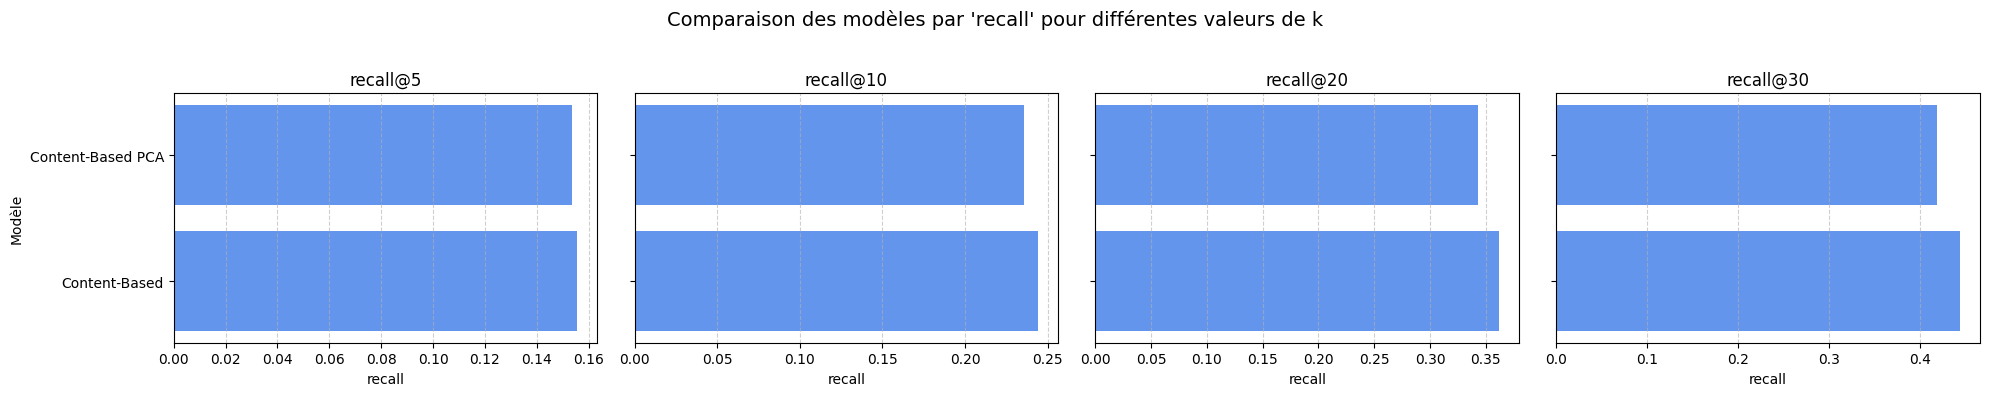

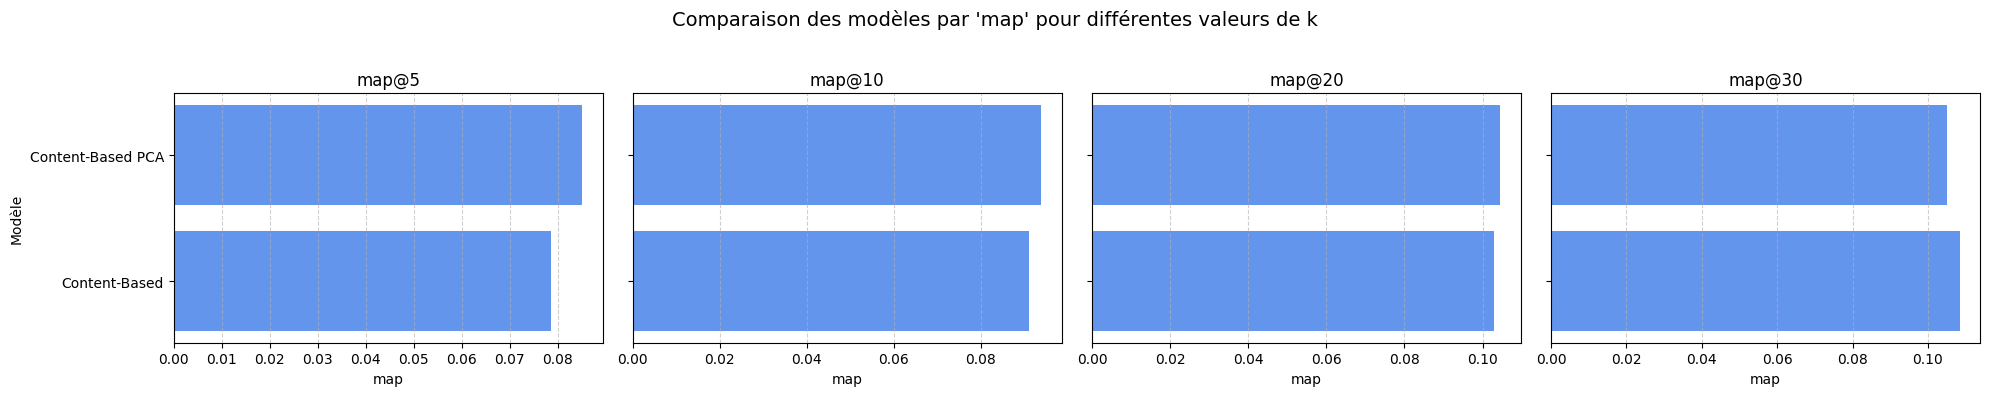

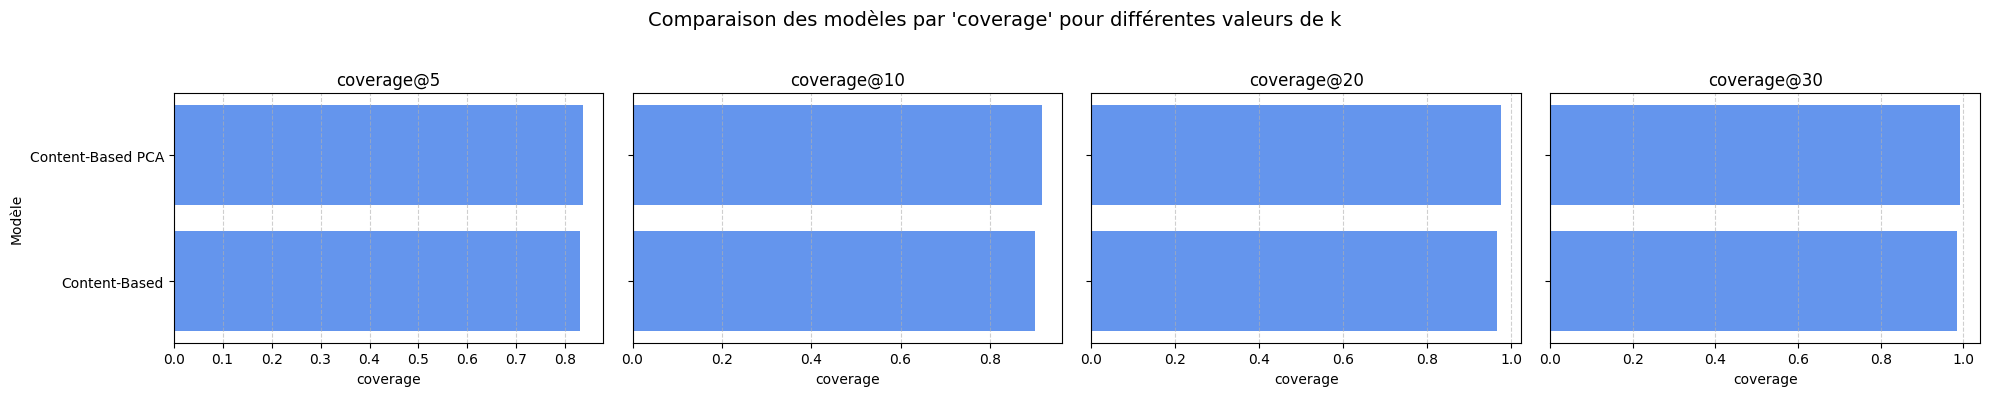

In [71]:
plot_model_comparison_by_k(cb_eval_k_df, metric="recall", ks=ks)
plot_model_comparison_by_k(cb_eval_k_df, metric="map", ks=ks)
plot_model_comparison_by_k(cb_eval_k_df, metric="coverage", ks=ks)

Dans une logique de déploiement optimisé sur Azure Function, nous avons compressé les embeddings des articles en appliquant une réduction de dimension via PCA. Cela a permis de passer d’un fichier de **350 Mo à 71 Mo**, tout en conservant des performances très proches du modèle initial.

Les différences de résultats restent faibles. Par exemple, à `k=30`, le **recall passe de 0.436 à 0.426**, le **MAP de 0.108 à 0.107**, et la **coverage reste quasi-identique** (0.99 contre 0.98). Ces écarts minimes confirment la robustesse du modèle réduit.

Ce compromis entre légèreté et efficacité justifie pleinement l’adoption de la version PCA compressée pour le déploiement final dans l’architecture cloud.


# Conclusion finale

Dans ce notebook, nous avons exploré, implémenté et comparé plusieurs approches de systèmes de recommandation basées sur :

- la popularité des articles,
- les similarités de contenu (Content-Based),
- le filtrage collaboratif implicite (ALS),
- et plusieurs modèles classiques basés sur des interactions explicites (SVD, NMF, KNN).

L’évaluation a été conduite à l’aide de métriques standards comme le recall@k, le MAP@k, le MRR@k et la couverture, et ce, pour différentes valeurs de `k`. Cela nous a permis d’identifier les forces et limites de chaque approche.

Le modèle basé sur la **popularité** a montré des performances très élevées tant que les articles populaires sont présents dans le jeu de test. Cependant, ses recommandations peu diversifiées et très génériques ont révélé une forte dépendance à un petit nombre d’articles dominants.

Le modèle **Content-Based** s’est montré bien plus robuste : il offre une **personnalisation plus fine**, une **très bonne couverture** (près de 90% à 99%) et une précision stable, ce qui en fait une solution particulièrement adaptée pour une première mise en production.

Le modèle **ALS**, quant à lui, constitue une solution intéressante pour une phase ultérieure, notamment dans un scénario où l’on disposerait d’un volume important d’interactions utilisateur.

Enfin, des fonctions ont été mises en place pour permettre une **intégration directe des recommandations dans une API ou une Azure Function**, rendant ce travail directement exploitable dans un environnement applicatif.